# RAG (Retrieval-Augmented Generation)

Терминът първо се появява в [Retrieval-Augmented Generation for Knowledge-Intensive NLP Tasks (Lewis et al., 2020)](https://arxiv.org/abs/2005.11401).

Оттогава концепцията бива постоянно развивана и RAG системи с различни архитектури биват проучвани и използвани както в академичните среди, така и в практиката.

Основната идея е следната:

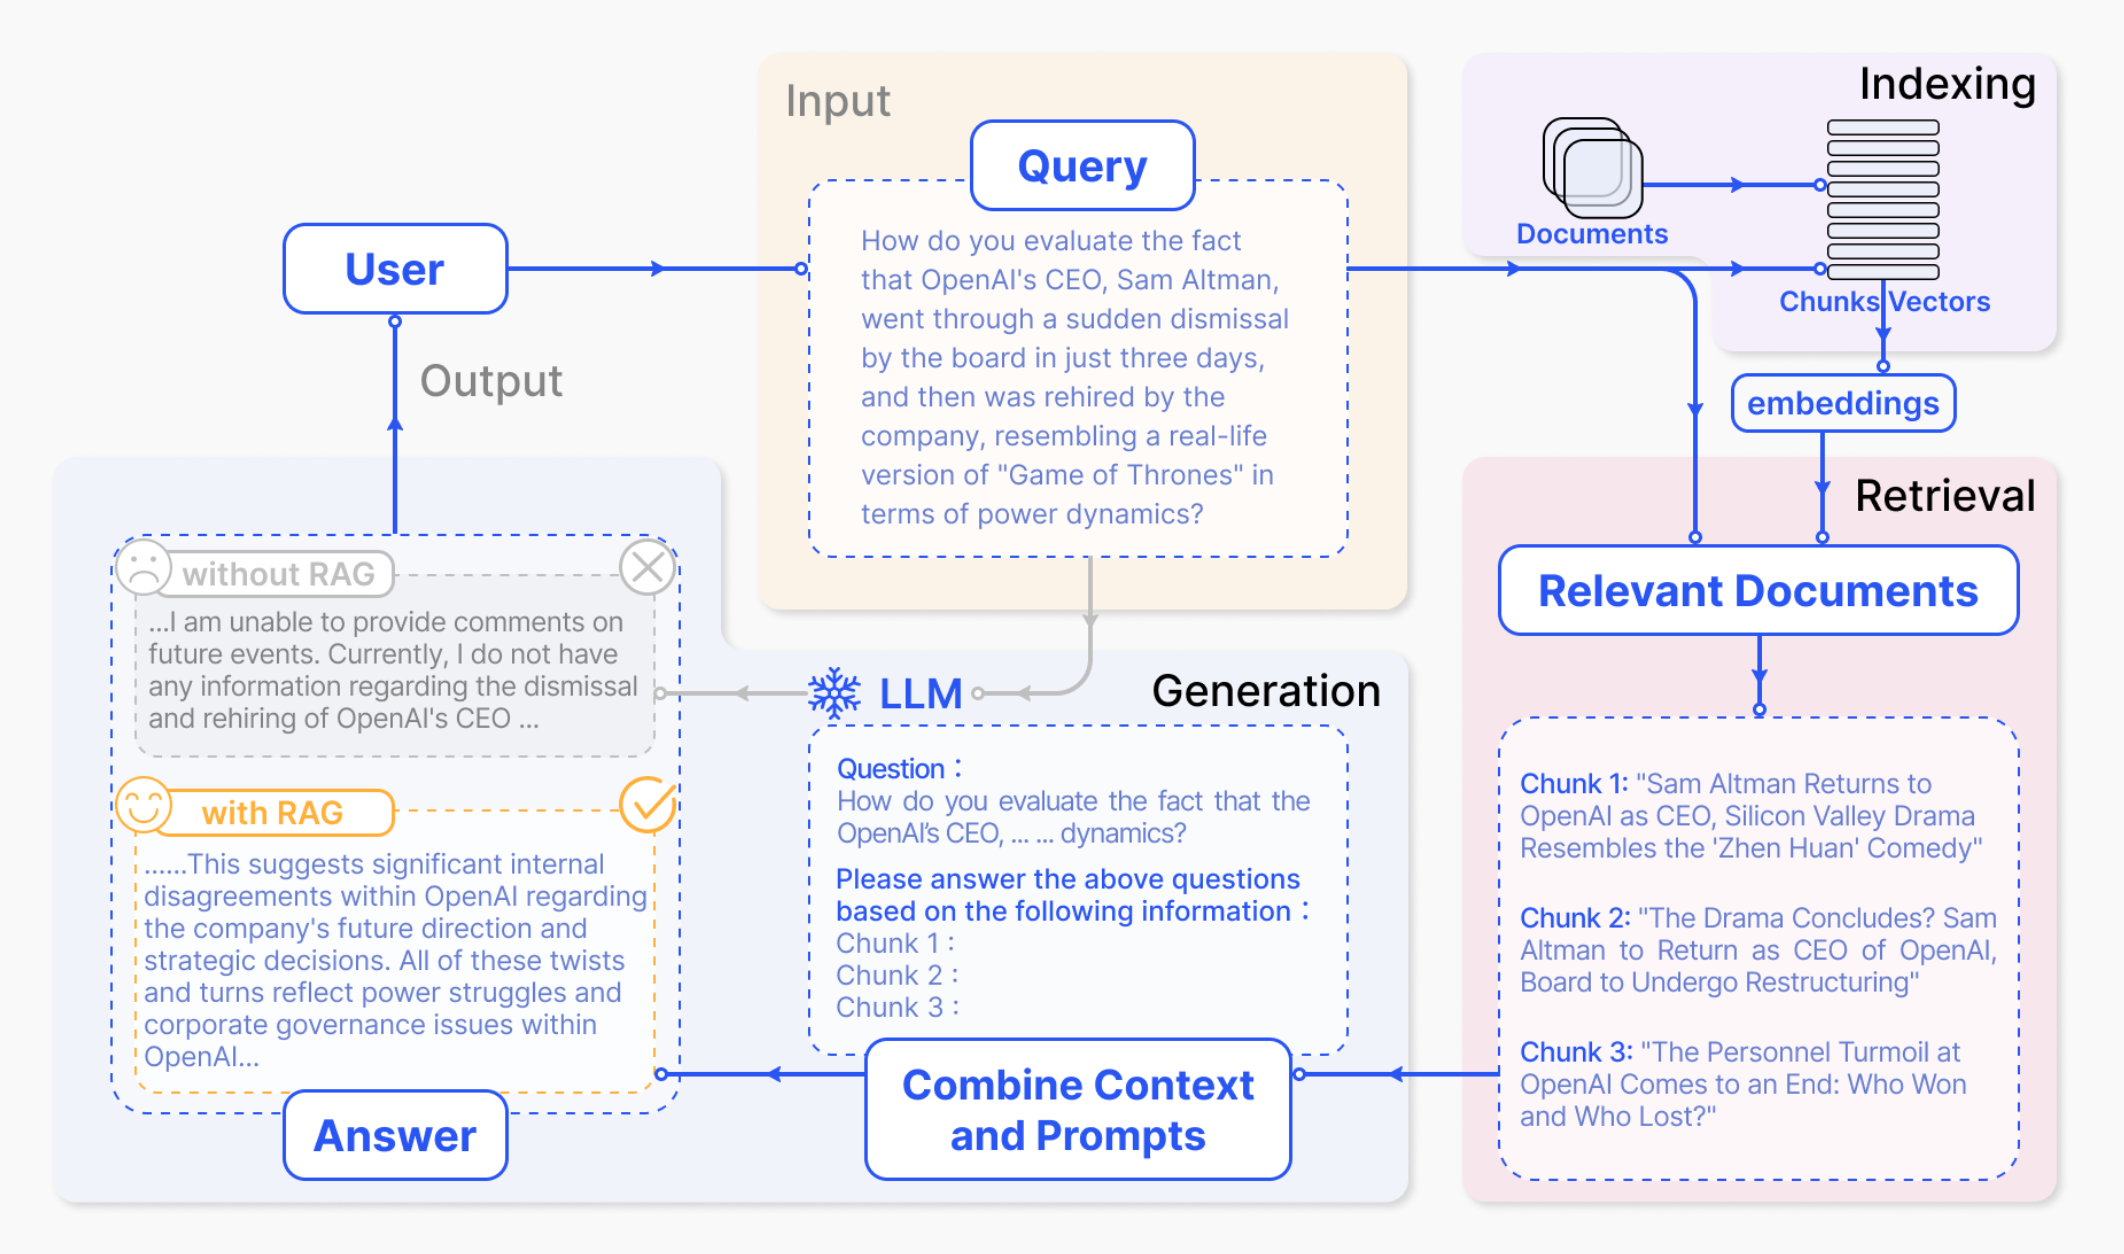

([*Retrieval-Augmented Generation for Large Language Models: A Survey (Yuan Gao et al., 2023)*](https://arxiv.org/abs/2312.10997))

1. Потребителят пише prompt/query (например задава въпрос или поставя задача на LLM-а)
2. Retrieval: Апп-ът ни взима само тези парчета от нашите документи, които са релевантни на потребителската заявка (близки по *смисъл*, не просто *съдържание*)
3. Обединява ги заедно с потребителската заявка в един цял prompt и така ги подава на LLM-а

**Индексирането** на **неструктурирана** информация най-често се прави чрез векторни бази от данни. Те съхраняват и правят лесни за достъпване вектори, репрезентиращи изреченията или думите в дадени текстове (както и метанформация).




### Защо **вектори**? (който знае какво е vector embedding, skip ahead)

Векторните embedding-и са начин да преобразуваме информация като категории, думи, изречения, снимки, звук и т.н. в такива вектори, които имат за цел за запазят връзките между отделните такива.

Прост пример за визуализация:

![vec embeddings example](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*jptD3Rur8gUOftw-XHrezQ.png)

*Имайте предвид, че 2 или дори 7 измерения са твърде недостатъчно, за да вършат работа тези embedding-и в реалния свят на естествените езици. Най-често за embedding-ите на думи се използват 512, 768 или 1024 измерения.*




### Как можем да търсим **по смисъл**, а не просто по съдържание?

Като превърнем думите във вектори по този начин, можем:
* да видим, че puppy е доста *близко* до dog, малко по-далече от cat и доста по-далече от house например
* да правим дори алгебрични операции с думите, като например

$$ king - man + woman = queen $$

"*Близост*" в езика на алгебрата може да се определи с различни операции (функции на два вектора $ a $ и $ b $):
* [косинусова близост](https://en.wikipedia.org/wiki/Cosine_similarity)

$$ \frac{a \cdot b}{|a| |b|} = \frac{\sum\limits_i a_i b_i}{\sqrt{\sum\limits_i a_i^2} \sqrt{\sum\limits_i b_i^2}} $$

*Нарича се така, понеже, ако ъгълът между двата вектора е $ \theta $, то може да се изрази и с $ a b \cos\theta $.*

* [Евклидово разстояние](https://en.wikipedia.org/wiki/Euclidean_distance)

$$ |a - b| = \sqrt{\sum\limits_i|a_i - b_i|^2} $$


* [Манхатъново разстояние](https://en.wikipedia.org/wiki/Taxicab_geometry)

$$ \sum\limits_i|a_i - b_i| $$

*Евклиидовото и Манхатъновото са мерките за изчисляване на разстояние съотв. в $ L_2 $ и $ L_1 $ пространствата, които са частни случаи на $ L_p $, чиято обобщена формула е:*

$$ |a - b|_p = \left(\sum\limits_i |a_i - b_i|^p \right)^{1/p} $$

### Е, хубаво де, ама кое да избера?

Кратък отговор: което е използвано в тренирането на embedding моделът, който сме избрали, за да превърнем думите/изреченията в embedding-и.

Обикновено се ползва косинусова близост, и затова е [зададена по подразбиране в `llama_index`](https://docs.llamaindex.ai/en/stable/module_guides/models/embeddings.html) или други библиотеки. Все пак, double-check-вайте.

*Note: Ако embedding векторите са нормирани до дължина $ 1 $, то косинусовото и Евклидовото разстояние ще дават идентични ранкинги, та няма значение кое бива избрано от гледна точка на резултат. От гледна точка на скорост, косинусовата близост ще може да се оптимизира да бъде една идея по-бърза, използвайки само скаларното умножение $ a \cdot b $.*


### А как да ги направя тези вектори in the first place? Къде да търся embedding model?

![embedding model](https://cdn.openai.com/new-and-improved-embedding-model/draft-20221214a/vectors-2.svg)

OpenAI имат сравнително [хубав](https://openai.com/blog/new-and-improved-embedding-model) и [евтин](https://openai.com/pricing#embedding-models) такъв, достъпен с [тяхното API](https://platform.openai.com/docs/guides/embeddings/what-are-embeddings).

Ако искаме open-source и/или безплатен модел, можем винаги да потърсим в [HuggingFace](https://huggingface.co/). За целите на RAG обикновено ни трябва [sentence transformer](https://huggingface.co/models?library=sentence-transformers) (да ембедваме цели изречения вместо отделни думи). Често използвани и добри такива (за английски език) са:
* [BAAI/bge-small-en-v1.5](https://huggingface.co/BAAI/bge-small-en-v1.5)
* [sentence-transformers/all-mpnet-base-v2](https://huggingface.co/sentence-transformers/all-mpnet-base-v2)
* [sentence-transformers/all-MiniLM-L6-v2](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2)
* [hkunlp/instructor-large](https://huggingface.co/hkunlp/instructor-large)

и др.




## Okay, enough talking now, let's code

Преди да изпълните каквото и да било, препоръчвам да конфигурирате тетрадката да ползва GPU вместо CPU. Google ни дава T4-ка с ~15GB RAM за без пари.

In [ ]:
!nvidia-smi  # да проверим дали е влкючено GPU-то

## Първо да оправим библиотеките

In [ ]:
!pip install git+https://github.com/huggingface/transformers
!pip install llama-index pypdf

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-8ud4or92
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-8ud4or92
  Resolved https://github.com/huggingface/transformers to commit 83f9196cc44a612ef2bd5a0f721d08cb24885c1f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
from llama_index import SimpleDirectoryReader, VectorStoreIndex, ServiceContext
from llama_index.node_parser import SentenceWindowNodeParser
from llama_index.llms import HuggingFaceLLM
from llama_index.postprocessor import MetadataReplacementPostProcessor
import os

## Index

[Index-ът](https://docs.llamaindex.ai/en/stable/understanding/indexing/indexing.html) с документи може да е под различни форми, като `llama_index` поддържа следните три структури:
* `VectorStoreIndex`
* `SummaryIndex`
* `KnowledgeGraphIndex`



Най-често използваните за целите на RAG index-и са vector embedding stores (a.k.a vector databases). Съществуват различни готови решения за тях, като например:
* [chroma](https://www.trychroma.com/) (easy use, self-hosted, completely free and open-source)
* [Pinecone](https://www.pinecone.io/) (cloud-based)
* [FAISS](https://ai.meta.com/tools/faiss/#:~:text=FAISS%20(Facebook%20AI%20Similarity%20Search,are%20similar%20to%20each%20other.) (by Meta)
* [Apache Cassandra v5.0+ ](https://cassandra.apache.org/_/index.html) (NoSQL DB, става и за vector search)
* [Redis](https://redis.io/docs/get-started/vector-database/)  (да, можем да ползваме Redis за vector DB)

За целите на демонстрацията ще ползваме `SimpleVectorStore`, който е in-memory vectore store index.


### Прочитане на файловете и създаване на node-ове

**Поставете вашите документи в долната директория:**

In [ ]:
DATA_DIR = "data"


Ще ни трябва някой `loader`, който да parse-не файловете ни в `Document` обекти.

Check out [Llama Hub](https://llamahub.ai/) за всякакви open-source community-made loader-и.

За целите на демото ще ползваме вградения `SimpleDirectoryReader` - чете наведнъж всичко от цяла директория, спрява се с PDF и доста други текстови формати.

In [ ]:
loader = SimpleDirectoryReader(DATA_DIR)
documents = loader.load_data()
len(documents)

60

In [ ]:
documents[10].text  # just visualize one sample

'king about something beyond duality, as when you use those slanting lines you\n are understood to be indicating a third dimension which cannot really be rep\nroduced on a two-dimensional surface.  That is the trick.\nIt is almost as if whatever we see to be different is an explicit difference \non the surface covering an implicit unity.  Only it is very difficult to talk\n about what it is that unifies black and white. (Of course, in a way the eyes\n do.  Sound and silence are unified by the cars).  If you cannot have one wit\nhout the other, it is like the north and south poles of a magnet.  You cannot\n have a one-pole magnet.  True, the poles are quite different; one is north a\nnd the other is south, but it is all one magnet.  This is what the Hindu is m\noving into when he is speaking of the real basis or ground of the universe as\n being non-dual.  Take, for example, the fundamental opposition that I suppos\ne all of us feel, between self and other-I and thou-I and it.  There is

За нашата цел може би ще е хубаво освен конкретното намерено изречение, да вземем и обкръващия го контекст. Затова вместо `SentenceSplitter` например ще ползваме [`SentenceWindowNodeParser`](https://docs.llamaindex.ai/en/stable/examples/node_postprocessor/MetadataReplacementDemo.html):

In [ ]:
node_parser = SentenceWindowNodeParser.from_defaults(
    window_size=5,  # контекст от 5 изречения
    window_metadata_key="window",
    original_text_metadata_key="original_text",
)

nodes = node_parser.get_nodes_from_documents(documents)
len(nodes)

1746

In [ ]:
sample_node = nodes[420]  # just visualize one sample
print(f"{sample_node.metadata['original_text'] = }")
print(f"{sample_node.metadata['window'] = }")

sample_node.metadata['original_text'] = 'It is called Brah\nma, and it is sometimes called om.  '
sample_node.metadata['window'] = 'The Brahma is what is basic, but the Brahma manifests itsel\nf in what are called the dvanva, and that makes the pairs of opposites (dua\nlity).   Dva is the Sanskrit word for "two," which becomes duo in Latin and \ndual in English.   Two is the basis, and you cannot go behind two, because o\nne has an opposite: the opposite of one is none.   Now, what is in common be\ntween one and none?   No one can sayyou can\'t mention it.   It is called Brah\nma, and it is sometimes called om.   Yet you can\'t really think of what is i\nn common between black and white, because there is obviously a conspiracy b\n'


Преди да създадем vector store index от тези node-ове, трябва да конфигурираме service context.

Service context-ът в llama_index е прост `dataclass`, в който посочваме какво ще ползваме: кой ще е LLM моделът, embedding моделът, параметри като node parser, chunk size и други настройки.


In [ ]:
# Още не сме си заредили LLM-ът - за създаването на embeddings не ни трябва и без това.
#
# (default-ът в `ServiceContext` е да ползва gpt-3.5-turbo (за който ви трябва OpenAI API key),
# затова трябва експлицитно да го сетнем на `None`.
# Пвече инфо за ServiceContext: https://docs.llamaindex.ai/en/stable/module_guides/supporting_modules/service_context.html)

service_context_store = ServiceContext.from_defaults(llm=None, embed_model="local:BAAI/bge-base-en-v1.5")

LLM is explicitly disabled. Using MockLLM.


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
index = VectorStoreIndex(nodes, service_context=service_context_store)
index

In [ ]:
index.storage_context.persist(persist_dir="store")  # запазваме си го за всеки случай

## LLM

Избрах [Mistral 7B](https://mistral.ai/news/announcing-mistral-7b/), понеже:
* е open-weights и с Apache 2.0 лиценз
* представя се по-добре от значително по-големи други модели (Llama-2 13B например)
* искаме 7-милиарден модел макс. (няма да натовари особено много T4 видео картата, ако ползваме 4-bit quantization, а иначе без компресия едва ще ни стигне мястото и най-вероятно ще крашне runtime-a)

В частност, ще ползваме [Instruct](https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.2) версията му, която е fine-tune-та за чат с модела.

In [ ]:
# за 4-bit компресията ще ни трябват accelerate и bitsandbytes
!pip install torch accelerate
!pip install -i https://test.pypi.org/simple/ bitsandbytes

Looking in indexes: https://test.pypi.org/simple/


In [ ]:
import torch
from transformers import BitsAndBytesConfig
from llama_index.prompts import PromptTemplate
from llama_index.llms import HuggingFaceLLM

# quantize-ваме параметрите му до 4-битови нормализирани float-ове, за да се събере в паметта на Т4-ката
# вместо оригиналните му ~15GB ще заема ~4GB
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,  # при inference, параметрите да се dequantize-вт в bfloat16, за по-голяма прецизност (с 4 бита на float само нищо няма да сметне)
)

llm = HuggingFaceLLM(  # този клас от llama_index автоматично вика `transformers` api-то under hood - тегли, разархивира и зарежда модела в паметта
    model_name="mistralai/Mistral-7B-Instruct-v0.2",  # точнoтo име от huggingface
    tokenizer_name="mistralai/Mistral-7B-Instruct-v0.2",  # обкновено е същия
    query_wrapper_prompt=PromptTemplate("<s>[INST] {query_str} [/INST] </s>\n"),  # всеки модел си има специфични prompt изисквания
    context_window=3900,
    max_new_tokens=256,
    model_kwargs={"quantization_config": quantization_config},
    generate_kwargs={"temperature": 0, "top_k": 5, "top_p": 0.95, "do_sample": True}, # по-малък temperature означава по-малък randomness (creativity). Мин-макс: 0-2
    device_map="auto",  # auto избира GPU ако има такова, иначе CPU
)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

(ще трябва да създадем наново index-ът, просто понеже по-рано му бяхме сложили service context без LLM с цел демо на създаването на ембединги само)

In [ ]:
service_context = ServiceContext.from_defaults(llm=llm, embed_model="local:BAAI/bge-base-en-v1.5", node_parser=node_parser)
index = VectorStoreIndex(nodes, service_context=service_context)
index

Query engine е улесняващата магия в `llama_index`, която прави целия процес по намирането и вмъкването на контекст лесен.

In [ ]:
query_engine = index.as_query_engine(
    similarity_top_k=3,  # най-близките К на брой chunk-ове да постави като контекст в prompt-a към LLM-a
    node_postprocessors=[
        MetadataReplacementPostProcessor(target_metadata_key="window")  # понеже вкарахме контекста на изреченията в `.metadata["window"]`, трябва да укажем на postprocessor-a къде се намира
    ],
)

### Готови сме вече да го питаме ~~човека~~ бота:

In [ ]:
response = query_engine.query("What books does the author recommend?")
response.response

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


'The author recommends the works of Alan Wittgenstein and an Englishman named Spencer-Brown. Specifically, he mentions Wittgenstein\'s Tractatus and Spencer-Brown\'s book "Laws of Form." The author finds value in these works for their insights into the nature of meaning and the limitations of language.'

Можем ръчно да проверим дали всичко е наред (и откъм LLM отговор, и откъм взет контекст) като видим какви node-ове сме взели и дали отговорът и контекстът горе-долу съвпадат с очаакванията ни:

In [ ]:
response.source_nodes

[NodeWithScore(node=TextNode(id_='47d186d9-2557-4bfa-bd4d-e9c1a07a7d5b', embedding=None, metadata={'window': 'If you rea\nlly are it, you don\'t need to believe in it, and you don\'t need to know it,\n just as your eyes don\'t need to look at themselves.   That is the differenc\ne of method in Buddhism.   Now, understand "method" here.   The method is a d\nialogue, and the so-called teachings of Buddhism are the first opening gamb\nits in the dialogue.   When they say you cannot understand Buddhism out of b\nooks, the reason is that the books only give you the opening gambits.   Then\n, having read the book, you have to go on with the method.   Now, you can go\n on with the method without a formal teacher.   That is to say, you can cond\nuct the dialogue with yourself or with life.   You have to explore and exper\niment on such things as "Could one possibly not desire?"  "Could one possibl\ny concentrate the mind perfectly?" ', 'original_text': 'Then\n, having read the book, you have t

## Ръчната проверка обаче... е ръчна. А и - с какви метрики се оценява такъв процес?

TBA

## Поразбрах RAG и ми е интересно да се (по-)занимавам с това. Оттук накъде?

В този tutorial покрих една от най-семплите и наивни архитектури за RAG, с бонус "advanced" концепцията на sentence window chunking. Съществуват още различни техники, които се изпоплзват, като reranking, knowledge bases, embedding model fine-tuning, и др. Следната диаграма от ([Retrieval-Augmented Generation for Large Language Models: A Survey (Yuan Gao et al., 2023)](https://arxiv.org/abs/2312.10997)) обобщава различните съществуващи RAG парадигми:

![RAG paradigms](https://i.imgur.com/slOIM2s_d.webp?maxwidth=1520&fidelity=grand)


Следващата диаграма категоризира и обяснява различните RAG техники, както и показва с кои модули от `llama_index` могат да се имплементират:

![advanced rag techniques](https://media.licdn.com/dms/image/D4D22AQFMnnrcrDn6Ig/feedshare-shrink_1280/0/1706013569232?e=1709164800&v=beta&t=BTuzwUG7xqdLKgwfav5ZNPV4JtdRmjKU7Nv8HV-TusE)

*Credit: [Eduardo Ordax](https://www.linkedin.com/feed/update/urn:li:activity:7155801412440842240/)*